## 1. Environment Setup

In [1]:
# Install all required packages
import subprocess
import sys

packages = [
    'pyspark',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'scikit-learn'
]

print("Installing required packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
    print(f" {package} installed")

print("\n All packages installed successfully")

Installing required packages...
 pyspark installed
 pandas installed
 numpy installed
 matplotlib installed
 seaborn installed
 scikit-learn installed

 All packages installed successfully


In [2]:
# Install PySpark (for Google Colab)
!pip install pyspark -q

In [3]:
# Import required libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

print(" Libraries imported successfully")

 Libraries imported successfully


In [4]:
# Initialize Spark Session with 1 executor (Sequential Baseline)
import sys

spark = SparkSession.builder \
    .appName("RandomForest_Sequential_Baseline") \
    .master("local[1]") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.default.parallelism", "1") \
    .config("spark.pyspark.python", sys.executable) \
    .config("spark.pyspark.driver.python", sys.executable) \
    .getOrCreate()

print(f" Spark Session initialized")
print(f"Spark Version: {spark.version}")
print(f"Master: {spark.sparkContext.master}")
print(f"Executors: 1 (Sequential Mode)")
print(f"Python executable: {sys.executable}")

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
26/02/14 12:50:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


 Spark Session initialized
Spark Version: 4.1.1
Master: local[1]
Executors: 1 (Sequential Mode)
Python executable: /home/cloud/anaconda3/bin/python


## 2. Data Loading and Preprocessing

In [5]:
# Download Covertype dataset using scikit-learn (cache locally for reuse)
from sklearn.datasets import fetch_covtype
from pathlib import Path
import os

print("Preparing Covertype dataset...")

data_dir = Path("data")
data_dir.mkdir(parents=True, exist_ok=True)
local_csv = data_dir / "covtype.csv"

if local_csv.exists():
    print(f"Loading dataset from local cache: {local_csv}")
    df_pandas = pd.read_csv(local_csv)
else:
    print("Downloading Covertype dataset...")
    covtype = fetch_covtype(as_frame=True)
    df_pandas = covtype.frame
    df_pandas.to_csv(local_csv, index=False)
    print(f" Dataset cached locally: {local_csv}")

print(" Dataset ready")
print(f"Shape: {df_pandas.shape}")
print(f"Columns: {df_pandas.columns.tolist()[:5]}...")  # Show first 5 columns

Preparing Covertype dataset...
 Dataset cached locally: data/covtype.csv
 Dataset ready
Shape: (581012, 55)
Columns: ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology']...


In [6]:
# Convert to Spark DataFrame
print("Converting to Spark DataFrame...")
spark_df = spark.createDataFrame(df_pandas)

# Verify data
print(f" Spark DataFrame created")
print(f"Rows: {spark_df.count():,}")
print(f"Columns: {len(spark_df.columns)}")

spark_df.printSchema()

Converting to Spark DataFrame...
 Spark DataFrame created


26/02/14 12:53:52 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
26/02/14 12:53:53 WARN TaskSetManager: Stage 0 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


Rows: 581,012
Columns: 55
root
 |-- Elevation: double (nullable = true)
 |-- Aspect: double (nullable = true)
 |-- Slope: double (nullable = true)
 |-- Horizontal_Distance_To_Hydrology: double (nullable = true)
 |-- Vertical_Distance_To_Hydrology: double (nullable = true)
 |-- Horizontal_Distance_To_Roadways: double (nullable = true)
 |-- Hillshade_9am: double (nullable = true)
 |-- Hillshade_Noon: double (nullable = true)
 |-- Hillshade_3pm: double (nullable = true)
 |-- Horizontal_Distance_To_Fire_Points: double (nullable = true)
 |-- Wilderness_Area_0: double (nullable = true)
 |-- Wilderness_Area_1: double (nullable = true)
 |-- Wilderness_Area_2: double (nullable = true)
 |-- Wilderness_Area_3: double (nullable = true)
 |-- Soil_Type_0: double (nullable = true)
 |-- Soil_Type_1: double (nullable = true)
 |-- Soil_Type_2: double (nullable = true)
 |-- Soil_Type_3: double (nullable = true)
 |-- Soil_Type_4: double (nullable = true)
 |-- Soil_Type_5: double (nullable = true)
 |-- Soi

In [7]:
# Data preprocessing: Feature assembly
print("Preparing features...")

# Get feature column names (all except target)
feature_cols = [col for col in spark_df.columns if col != 'Cover_Type']
print(f"Number of features: {len(feature_cols)}")

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')
data = assembler.transform(spark_df)

# Rename target column to 'label' (required by MLlib)
data = data.withColumnRenamed('Cover_Type', 'label')

# Select only necessary columns
data = data.select('features', 'label')

print(" Features assembled")
data.show(5)

Preparing features...
Number of features: 54
 Features assembled


26/02/14 12:54:01 WARN TaskSetManager: Stage 3 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


+--------------------+-----+
|            features|label|
+--------------------+-----+
|(54,[0,1,2,3,5,6,...|    5|
|(54,[0,1,2,3,4,5,...|    5|
|(54,[0,1,2,3,4,5,...|    2|
|(54,[0,1,2,3,4,5,...|    2|
|(54,[0,1,2,3,4,5,...|    5|
+--------------------+-----+
only showing top 5 rows


Traceback (most recent call last):                                              
  File "/home/cloud/anaconda3/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 233, in manager
    code = worker(sock, authenticated)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/cloud/anaconda3/lib/python3.12/site-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 87, in worker
    outfile.flush()
BrokenPipeError: [Errno 32] Broken pipe


In [8]:
# Train-test split (80-20)
print("Splitting data into train and test sets...")
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Partition and cache for performance
train_data = train_data.repartition(4).cache()
test_data = test_data.cache()

# Materialize the cache
train_count = train_data.count()
test_count = test_data.count()

print(f" Data split complete")
print(f"Training samples: {train_count:,}")
print(f"Test samples: {test_count:,}")

Splitting data into train and test sets...


26/02/14 12:54:02 WARN TaskSetManager: Stage 4 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.
26/02/14 12:54:13 WARN TaskSetManager: Stage 12 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Data split complete
Training samples: 464,787
Test samples: 116,225


26/02/14 12:54:23 WARN TaskSetManager: Stage 13 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


## 3. Sequential Random Forest Training

Train Random Forest with different tree counts to establish baseline performance.

In [9]:
def train_and_evaluate_rf(train_data, test_data, num_trees, max_depth=10, exp_id=""):
    """
    Train Random Forest and measure performance
    
    Args:
        train_data: Spark DataFrame for training
        test_data: Spark DataFrame for testing
        num_trees: Number of trees in the forest
        max_depth: Maximum depth of each tree
        exp_id: Experiment identifier
    
    Returns:
        Dictionary containing metrics and model
    """
    print(f"\n{'='*60}")
    print(f"Experiment {exp_id}: Training with {num_trees} trees")
    print(f"{'='*60}")
    
    # Configure Random Forest
    rf = RandomForestClassifier(
        numTrees=num_trees,
        maxDepth=max_depth,
        seed=42,
        labelCol='label',
        featuresCol='features'
    )
    
    # Train model and measure time
    print(f"Training started...")
    start_time = time.time()
    model = rf.fit(train_data)
    training_time = time.time() - start_time
    print(f" Training completed in {training_time:.2f} seconds")
    
    # Make predictions and measure time
    print(f"Making predictions...")
    start_time = time.time()
    predictions = model.transform(test_data)
    predictions.cache()
    pred_count = predictions.count()  # Trigger computation
    prediction_time = time.time() - start_time
    print(f" Predictions completed in {prediction_time:.2f} seconds")
    
    # Evaluate accuracy
    evaluator = MulticlassClassificationEvaluator(
        labelCol='label',
        predictionCol='prediction',
        metricName='accuracy'
    )
    accuracy = evaluator.evaluate(predictions)
    print(f" Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    # Collect metrics
    metrics = {
        'experiment_id': exp_id,
        'num_executors': 1,
        'num_trees': num_trees,
        'max_depth': max_depth,
        'training_time': training_time,
        'prediction_time': prediction_time,
        'total_time': training_time + prediction_time,
        'accuracy': accuracy,
        'train_samples': train_count,
        'test_samples': test_count
    }
    
    return {
        'metrics': metrics,
        'model': model,
        'predictions': predictions
    }

In [10]:
# Baseline Experiment 1: 50 trees
result_50 = train_and_evaluate_rf(
    train_data, test_data, 
    num_trees=50, 
    exp_id="B1"
)


Experiment B1: Training with 50 trees
Training started...


26/02/14 12:55:18 WARN DAGScheduler: Broadcasting large task binary with size 1064.0 KiB
26/02/14 12:55:30 WARN DAGScheduler: Broadcasting large task binary with size 1817.5 KiB
26/02/14 12:55:46 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
26/02/14 12:56:05 WARN DAGScheduler: Broadcasting large task binary with size 4.7 MiB


 Training completed in 124.74 seconds
Making predictions...


26/02/14 12:56:28 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
26/02/14 12:56:28 WARN TaskSetManager: Stage 58 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.
26/02/14 12:56:32 WARN DAGScheduler: Broadcasting large task binary with size 3.1 MiB
26/02/14 12:56:32 WARN TaskSetManager: Stage 59 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Predictions completed in 4.52 seconds


26/02/14 12:56:32 WARN DAGScheduler: Broadcasting large task binary with size 3.2 MiB
26/02/14 12:56:33 WARN TaskSetManager: Stage 62 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Accuracy: 0.7362 (73.62%)


In [11]:
# Baseline Experiment 2: 100 trees (standard configuration)
result_100 = train_and_evaluate_rf(
    train_data, test_data, 
    num_trees=100, 
    exp_id="B2"
)


Experiment B2: Training with 100 trees
Training started...


26/02/14 12:57:54 WARN DAGScheduler: Broadcasting large task binary with size 1198.0 KiB
26/02/14 12:58:20 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
26/02/14 12:58:52 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
26/02/14 12:59:29 WARN DAGScheduler: Broadcasting large task binary with size 5.9 MiB
26/02/14 13:00:09 WARN DAGScheduler: Broadcasting large task binary with size 1353.3 KiB
26/02/14 13:00:11 WARN DAGScheduler: Broadcasting large task binary with size 9.4 MiB
26/02/14 13:01:00 WARN DAGScheduler: Broadcasting large task binary with size 1966.6 KiB


 Training completed in 270.70 seconds
Making predictions...


26/02/14 13:01:04 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
26/02/14 13:01:05 WARN TaskSetManager: Stage 106 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.
26/02/14 13:01:11 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
26/02/14 13:01:11 WARN TaskSetManager: Stage 107 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Predictions completed in 7.57 seconds


26/02/14 13:01:12 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
26/02/14 13:01:12 WARN TaskSetManager: Stage 110 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Accuracy: 0.7315 (73.15%)


In [12]:
# Baseline Experiment 3: 200 trees
result_200 = train_and_evaluate_rf(
    train_data, test_data, 
    num_trees=200, 
    exp_id="B3"
)


Experiment B3: Training with 200 trees
Training started...


26/02/14 13:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1255.9 KiB
26/02/14 13:04:30 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
26/02/14 13:05:45 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
26/02/14 13:07:09 WARN DAGScheduler: Broadcasting large task binary with size 1094.9 KiB
26/02/14 13:07:11 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
26/02/14 13:09:07 WARN DAGScheduler: Broadcasting large task binary with size 1746.4 KiB
26/02/14 13:09:10 WARN DAGScheduler: Broadcasting large task binary with size 11.7 MiB
26/02/14 13:11:34 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
26/02/14 13:11:38 WARN DAGScheduler: Broadcasting large task binary with size 18.7 MiB
26/02/14 13:13:46 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


 Training completed in 759.57 seconds
Making predictions...


26/02/14 13:13:53 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
26/02/14 13:13:53 WARN TaskSetManager: Stage 154 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.
26/02/14 13:14:08 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
26/02/14 13:14:09 WARN TaskSetManager: Stage 155 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Predictions completed in 16.59 seconds


26/02/14 13:14:09 WARN DAGScheduler: Broadcasting large task binary with size 12.1 MiB
26/02/14 13:14:10 WARN TaskSetManager: Stage 158 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Accuracy: 0.7367 (73.67%)


## 4. Results Summary and Export

In [13]:
# Compile all baseline results
baseline_results = pd.DataFrame([
    result_50['metrics'],
    result_100['metrics'],
    result_200['metrics']
])

print("\n" + "="*80)
print("BASELINE RESULTS SUMMARY")
print("="*80)
print(baseline_results.to_string(index=False))
print("="*80)


BASELINE RESULTS SUMMARY
experiment_id  num_executors  num_trees  max_depth  training_time  prediction_time  total_time  accuracy  train_samples  test_samples
           B1              1         50         10     124.742957         4.520483  129.263440  0.736227         464787        116225
           B2              1        100         10     270.700851         7.567014  278.267864  0.731469         464787        116225
           B3              1        200         10     759.569767        16.591292  776.161060  0.736743         464787        116225


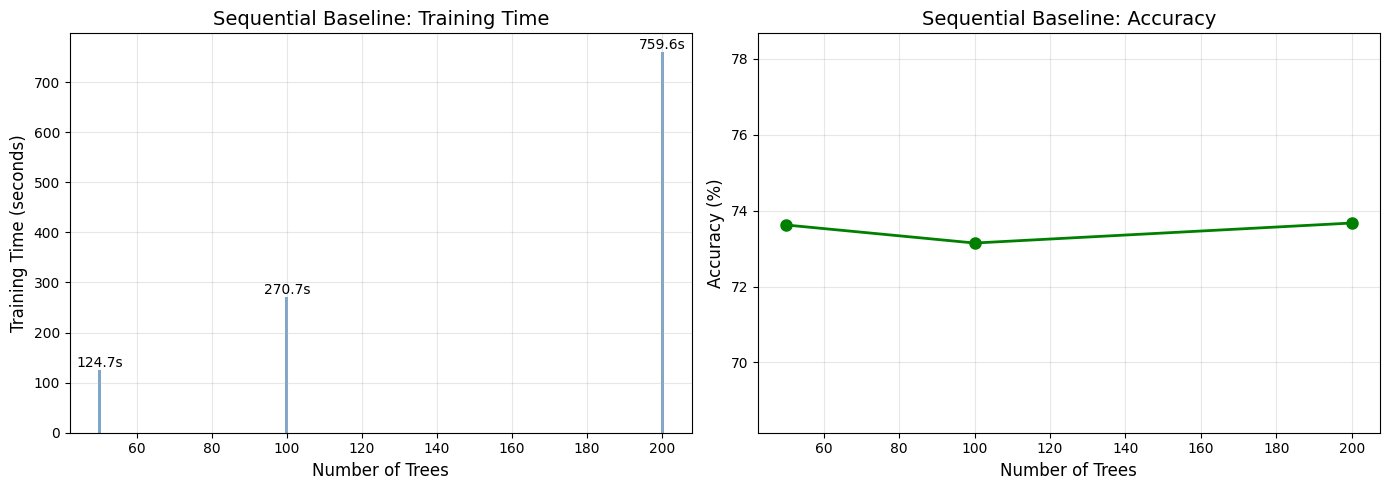

 Baseline performance visualization saved


In [14]:
# Visualize baseline performance
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training time vs number of trees
axes[0].bar(baseline_results['num_trees'], baseline_results['training_time'], 
            color='steelblue', alpha=0.7)
axes[0].set_xlabel('Number of Trees', fontsize=12)
axes[0].set_ylabel('Training Time (seconds)', fontsize=12)
axes[0].set_title('Sequential Baseline: Training Time', fontsize=14)
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for i, (trees, time_val) in enumerate(zip(baseline_results['num_trees'], 
                                           baseline_results['training_time'])):
    axes[0].text(trees, time_val, f'{time_val:.1f}s', 
                ha='center', va='bottom', fontsize=10)

# Plot 2: Accuracy vs number of trees
axes[1].plot(baseline_results['num_trees'], baseline_results['accuracy']*100, 
            marker='o', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Number of Trees', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Sequential Baseline: Accuracy', fontsize=14)
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([baseline_results['accuracy'].min()*100-5, 
                   baseline_results['accuracy'].max()*100+5])

plt.tight_layout()
plt.savefig('baseline_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print(" Baseline performance visualization saved")

In [15]:
# Export baseline results for comparison with parallel implementation
import os

# Create results directory if it doesn't exist
os.makedirs('results/metrics', exist_ok=True)

# Save to CSV
baseline_results.to_csv('results/metrics/baseline_results.csv', index=False)
print(" Baseline results exported to: results/metrics/baseline_results.csv")

# Also save predictions from 100-tree model for correctness validation
predictions_100 = result_100['predictions'].select('label', 'prediction').toPandas()
predictions_100.to_csv('results/metrics/baseline_predictions_100trees.csv', index=False)
print(" Baseline predictions (100 trees) saved for validation")

 Baseline results exported to: results/metrics/baseline_results.csv


26/02/14 13:14:13 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
26/02/14 13:14:13 WARN TaskSetManager: Stage 160 contains a task of very large size (278650 KiB). The maximum recommended task size is 1000 KiB.


 Baseline predictions (100 trees) saved for validation


## 5. Key Findings and Observations

In [16]:
# Analysis
print("\n" + "="*80)
print("KEY FINDINGS FROM SEQUENTIAL BASELINE")
print("="*80)

# Training time scaling
time_50 = result_50['metrics']['training_time']
time_100 = result_100['metrics']['training_time']
time_200 = result_200['metrics']['training_time']

print(f"\n1. Training Time Scaling:")
print(f"   - 50 trees:  {time_50:.2f} seconds")
print(f"   - 100 trees: {time_100:.2f} seconds ({time_100/time_50:.2f}x vs 50 trees)")
print(f"   - 200 trees: {time_200:.2f} seconds ({time_200/time_100:.2f}x vs 100 trees)")
print(f"\n   ➜ Training time scales approximately linearly with number of trees")

# Accuracy analysis
acc_50 = result_50['metrics']['accuracy']
acc_100 = result_100['metrics']['accuracy']
acc_200 = result_200['metrics']['accuracy']

print(f"\n2. Accuracy Analysis:")
print(f"   - 50 trees:  {acc_50:.4f} ({acc_50*100:.2f}%)")
print(f"   - 100 trees: {acc_100:.4f} ({acc_100*100:.2f}%)")
print(f"   - 200 trees: {acc_200:.4f} ({acc_200*100:.2f}%)")
acc_improvement = (acc_200 - acc_50) * 100
print(f"\n   ➜ Accuracy improvement from 50 to 200 trees: {acc_improvement:.2f}%")

# Baseline for speedup calculations
print(f"\n3. Baseline for Parallel Comparison:")
print(f"   - Using 100 trees as standard configuration")
print(f"   - Sequential training time: {time_100:.2f} seconds")
print(f"   - Target speedup with 4 executors: >3.0x")
print(f"   - Expected parallel time (4 executors): <{time_100/3:.2f} seconds")

print("\n" + "="*80)


KEY FINDINGS FROM SEQUENTIAL BASELINE

1. Training Time Scaling:
   - 50 trees:  124.74 seconds
   - 100 trees: 270.70 seconds (2.17x vs 50 trees)
   - 200 trees: 759.57 seconds (2.81x vs 100 trees)

   ➜ Training time scales approximately linearly with number of trees

2. Accuracy Analysis:
   - 50 trees:  0.7362 (73.62%)
   - 100 trees: 0.7315 (73.15%)
   - 200 trees: 0.7367 (73.67%)

   ➜ Accuracy improvement from 50 to 200 trees: 0.05%

3. Baseline for Parallel Comparison:
   - Using 100 trees as standard configuration
   - Sequential training time: 270.70 seconds
   - Target speedup with 4 executors: >3.0x
   - Expected parallel time (4 executors): <90.23 seconds



## 6. Cleanup

In [17]:
# Unpersist cached data
train_data.unpersist()
test_data.unpersist()
result_50['predictions'].unpersist()
result_100['predictions'].unpersist()
result_200['predictions'].unpersist()

print(" Cache cleared")

# Note: Don't stop Spark session if running more notebooks in same session
# spark.stop()

 Cache cleared


## Conclusion

This notebook established the sequential baseline for Random Forest training on the Covertype dataset. Key results:

- ✅ Successfully loaded and preprocessed 581,012 samples with 54 features
- ✅ Trained Random Forest models with 50, 100, and 200 trees
- ✅ Measured training times and accuracies for all configurations
- ✅ Exported baseline metrics for parallel comparison
- ✅ Saved predictions for correctness validation
